## ThinkDSP

This notebook contains code examples from Chapter 7: Discrete Fourier Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np

PI2 = 2 * np.pi

Here's the definition of ComplexSinusoid, with print statements to display intermediate results.

In [2]:
class ComplexSinusoid(thinkdsp.Sinusoid):
    """Represents a complex exponential signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        print(ts)
        phases = PI2 * self.freq * ts + self.offset
        print(phases)
        ys = self.amp * np.exp(1j * phases)
        return ys

Here's an example:

In [3]:
signal = ComplexSinusoid(freq=1, amp=0.6, offset=1)
wave = signal.make_wave(duration=1, framerate=4)
print(wave.ys)

[0.   0.25 0.5  0.75]
[1.         2.57079633 4.14159265 5.71238898]
[ 0.32418138+0.50488259j -0.50488259+0.32418138j -0.32418138-0.50488259j
  0.50488259-0.32418138j]


The simplest way to synthesize a mixture of signals is to evaluate the signals and add them up.

In [4]:
def synthesize1(amps, freqs, ts):
    components = [thinkdsp.ComplexSinusoid(freq, amp)
                  for amp, freq in zip(amps, freqs)]
    signal = thinkdsp.SumSignal(*components)
    ys = signal.evaluate(ts)
    return ys

Here's an example that's a mixture of 4 components.

In [5]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys = synthesize1(amps, freqs, ts)
print(ys)

[1.        +0.j         0.99465216+0.09092275j 0.9787423 +0.18028474j ...
 0.95266642-0.26657509j 0.9787423 -0.18028474j 0.99465216-0.09092275j]


Now we can plot the real and imaginary parts:

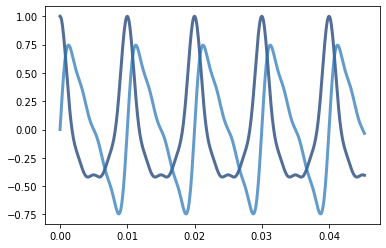

In [6]:
n = 500
thinkplot.plot(ts[:n], ys[:n].real)
thinkplot.plot(ts[:n], ys[:n].imag)

The real part is a mixture of cosines; the imaginary part is a mixture of sines.  They contain the same frequency components with the same amplitudes, so they sound the same to us:

In [7]:
wave = thinkdsp.Wave(ys.real, framerate)
wave.apodize()
wave.make_audio()

In [8]:
wave = thinkdsp.Wave(ys.imag, framerate)
wave.apodize()
wave.make_audio()

We can express the same process using matrix multiplication.

In [9]:
def synthesize2(amps, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    ys = np.dot(M, amps)
    return ys

And it should sound the same.

In [10]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
ys = synthesize2(amps, freqs, ts)
print(ys)

[1.        +0.j         0.99465216+0.09092275j 0.9787423 +0.18028474j ...
 0.95266642-0.26657509j 0.9787423 -0.18028474j 0.99465216-0.09092275j]


In [11]:
wave = thinkdsp.Wave(ys.real, framerate)
wave.apodize()
wave.make_audio()

To see the effect of a complex amplitude, we can rotate the amplitudes by 1.5 radian:

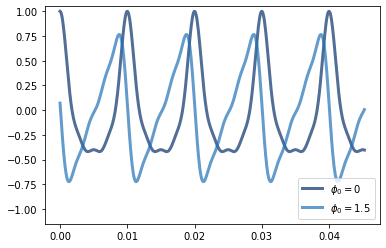

In [12]:
phi = 1.5
amps2 = amps * np.exp(1j * phi)
ys2 = synthesize2(amps2, freqs, ts)

n = 500
thinkplot.plot(ts[:n], ys.real[:n], label=r'$\phi_0 = 0$')
thinkplot.plot(ts[:n], ys2.real[:n], label=r'$\phi_0 = 1.5$')
thinkplot.config(ylim=[-1.15, 1.05], loc='lower right')

Rotating all components by the same phase offset changes the shape of the waveform because the components have different periods, so the same offset has a different effect on each component.

### Analysis

The simplest way to analyze a signal---that is, find the amplitude for each component---is to create the same matrix we used for synthesis and then solve the system of linear equations.

In [13]:
def analyze1(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Using the first 4 values from the wave array, we can recover the amplitudes.

In [14]:
n = len(freqs)
amps2 = analyze1(ys[:n], freqs, ts[:n])
print(amps2)

[0.6 -5.06782787e-13j 0.25+1.48132058e-12j 0.1 -1.43555952e-12j
 0.05+4.61028767e-13j]


If we define the `freqs` from 0 to N-1 and `ts` from 0 to (N-1)/N, we get a unitary matrix. 

In [15]:
N = 4
ts = np.arange(N) / N
freqs = np.arange(N)
args = np.outer(ts, freqs)
M = np.exp(1j * PI2 * args)
print(M)

[[ 1.0000000e+00+0.0000000e+00j  1.0000000e+00+0.0000000e+00j
   1.0000000e+00+0.0000000e+00j  1.0000000e+00+0.0000000e+00j]
 [ 1.0000000e+00+0.0000000e+00j  6.1232340e-17+1.0000000e+00j
  -1.0000000e+00+1.2246468e-16j -1.8369702e-16-1.0000000e+00j]
 [ 1.0000000e+00+0.0000000e+00j -1.0000000e+00+1.2246468e-16j
   1.0000000e+00-2.4492936e-16j -1.0000000e+00+3.6739404e-16j]
 [ 1.0000000e+00+0.0000000e+00j -1.8369702e-16-1.0000000e+00j
  -1.0000000e+00+3.6739404e-16j  5.5109106e-16+1.0000000e+00j]]


To check whether a matrix is unitary, we can compute $M^* M$, which should be the identity matrix:

In [18]:
MstarM = M.conj().transpose().dot(M)
print(MstarM.real)

[[ 4.00000000e+00 -1.83697020e-16  0.00000000e+00  3.29046455e-16]
 [-1.83697020e-16  4.00000000e+00 -1.72254642e-16  0.00000000e+00]
 [ 0.00000000e+00 -1.72254642e-16  4.00000000e+00 -8.41170949e-17]
 [ 3.29046455e-16  0.00000000e+00 -8.41170949e-17  4.00000000e+00]]


The result is actually $4 I$, so in general we have an extra factor of $N$ to deal with, but that's a minor problem.

We can use this result to write a faster version of `analyze1`:


In [19]:
def analyze2(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    amps = M.conj().transpose().dot(ys) / N
    return amps

In [20]:
N = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = np.arange(N)
ts = np.arange(N) / N
ys = synthesize2(amps, freqs, ts)

amps3 = analyze2(ys, freqs, ts)
print(amps3)

[0.6 +2.08166817e-17j 0.25+6.12323400e-18j 0.1 -4.36782979e-17j
 0.05-8.44960014e-17j]


Now we can write our own version of DFT:

In [21]:
def synthesis_matrix(N):
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(1j * PI2 * args)
    return M

In [22]:
def dft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys)
    return amps

And compare it to analyze2:

In [23]:
print(dft(ys))

[2.4+8.32667268e-17j 1. +2.44929360e-17j 0.4-1.74713192e-16j
 0.2-3.37984006e-16j]


The result is close to `amps * 4`.

We can also compare it to `np.fft.fft`.  FFT stands for Fast Fourier Transform, which is an even faster implementation of DFT.

In [24]:
print(np.fft.fft(ys))

[2.4+8.00040872e-17j 1. -2.44929360e-17j 0.4-3.10182152e-17j
 0.2-2.44929360e-17j]


The inverse DFT is almost the same, except we don't have to transpose $M$ and we have to divide through by $N$.

In [25]:
def idft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.dot(ys) / N
    return amps

We can confirm that `dft(idft(amps))` yields `amps`:

In [26]:
ys = idft(amps)
print(dft(ys))

[0.6 +2.08166817e-17j 0.25+6.12323400e-18j 0.1 -4.36782979e-17j
 0.05-8.44960014e-17j]


### Real signals

Let's see what happens when we apply DFT to a real-valued signal.

In [27]:
framerate = 10000
signal = thinkdsp.SawtoothSignal(freq=500)
wave = signal.make_wave(duration=0.1, framerate=framerate)
wave.make_audio()

`wave` is a 500 Hz sawtooth signal sampled at 10 kHz.

In [28]:
hs = dft(wave.ys)
len(wave.ys), len(hs)

(1000, 1000)

`hs` is the DFT of this wave, and `amps` contains the amplitudes.

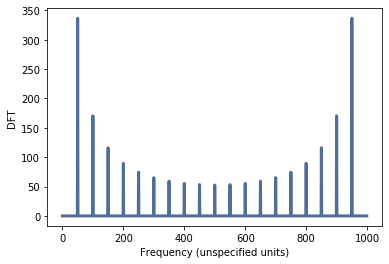

In [29]:
amps = np.absolute(hs)
thinkplot.plot(amps)
thinkplot.config(xlabel='Frequency (unspecified units)', ylabel='DFT')

The DFT assumes that the sampling rate is N per time unit, for an arbitrary time unit.  We have to convert to actual units -- seconds -- like this:

In [30]:
N = len(hs)
fs = np.arange(N) * framerate / N

Also, the DFT of a real signal is symmetric, so the right side is redundant.  Normally, we only compute and plot the first half:

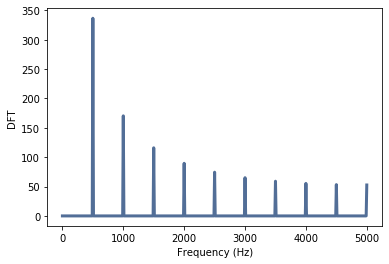

In [31]:
thinkplot.plot(fs[:N//2+1], amps[:N//2+1])
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DFT')

Let's get a better sense for why the DFT of a real signal is symmetric.  I'll start by making the inverse DFT matrix for $N=8$.

In [32]:
M = synthesis_matrix(N=8)

And the DFT matrix:

In [33]:
Mstar = M.conj().transpose()

And a triangle wave with 8 elements:

In [34]:
wave = thinkdsp.TriangleSignal(freq=1).make_wave(duration=1, framerate=8)
wave.ys

array([ 1. ,  0.5,  0. , -0.5, -1. , -0.5,  0. ,  0.5])

Here's what the wave looks like.

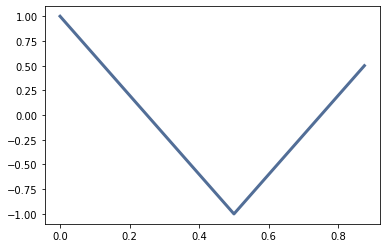

In [35]:
wave.plot()

Now let's look at rows 3 and 5 of the DFT matrix:

In [36]:
row3 = Mstar[3, :]
print(row3)

[ 1.00000000e+00-0.00000000e+00j -7.07106781e-01-7.07106781e-01j
 -1.83697020e-16+1.00000000e+00j  7.07106781e-01-7.07106781e-01j
 -1.00000000e+00-3.67394040e-16j  7.07106781e-01+7.07106781e-01j
  5.51091060e-16-1.00000000e+00j -7.07106781e-01+7.07106781e-01j]


In [37]:
row5 = Mstar[5, :]
row5

array([ 1.00000000e+00-0.00000000e+00j, -7.07106781e-01+7.07106781e-01j,
        3.06161700e-16-1.00000000e+00j,  7.07106781e-01+7.07106781e-01j,
       -1.00000000e+00-6.12323400e-16j,  7.07106781e-01-7.07106781e-01j,
       -2.69484194e-15+1.00000000e+00j, -7.07106781e-01-7.07106781e-01j])

They are almost the same, but row5 is the complex conjugate of row3.

In [38]:
def approx_equal(a, b, tol=1e-10):
    return sum(abs(a-b)) < tol

In [39]:
approx_equal(row3, row5.conj())

True

When we multiply the DFT matrix and the wave array, the element with index 3 is:

In [40]:
X3 = row3.dot(wave.ys)
X3

(0.5857864376269053-1.322063213371145e-16j)

And the element with index 5 is:

In [41]:
X5 = row5.dot(wave.ys)
X5

(0.585786437626906-5.534107762827377e-16j)

And they are the same, within floating point error.

In [42]:
abs(X3 - X5)

7.881290833695066e-16

Let's try the same thing with a complex signal:

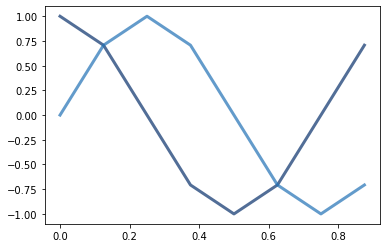

In [43]:
wave2 = thinkdsp.ComplexSinusoid(freq=1).make_wave(duration=1, framerate=8)
thinkplot.plot(wave2.ts, wave2.ys.real)
thinkplot.plot(wave2.ts, wave2.ys.imag)

Now the elements with indices 3 and 5 are different:

In [44]:
X3 = row3.dot(wave2.ys)
X3

(1.5543122344752192e-15-4.1146281352324417e-16j)

In [45]:
X5 = row5.dot(wave2.ys)
X5

(-2.220446049250313e-16+2.4833083188915175e-16j)

Visually we can confirm that the FFT of the real signal is symmetric:

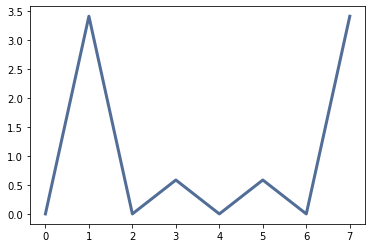

In [46]:
hs = np.fft.fft(wave.ys)
thinkplot.plot(abs(hs))

And the FFT of the complex signal is not.

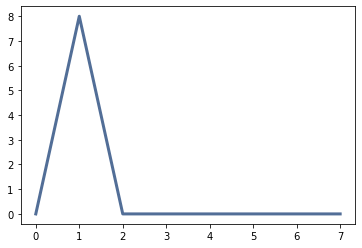

In [47]:
hs = np.fft.fft(wave2.ys)
thinkplot.plot(abs(hs))

Another way to think about all of this is to evaluate the DFT matrix for different frequencies.  Instead of $0$ through $N-1$, let's try $0, 1, 2, 3, 4, -3, -2, -1$.

In [48]:
N = 8
ts = np.arange(N) / N
freqs = np.arange(N)
freqs = [0, 1, 2, 3, 4, -3, -2, -1]
args = np.outer(ts, freqs)
M2 = np.exp(1j * PI2 * args)

In [49]:
approx_equal(M, M2)

array([ True,  True,  True,  True,  True,  True,  True,  True])

So you can think of the second half of the DFT as positive frequencies that get aliased (which is how I explained them), or as negative frequencies (which is the more conventional way to explain them).  But the DFT doesn't care either way.

The `thinkdsp` library provides support for computing the "full" FFT instead of the real FFT.

In [50]:
framerate = 10000
signal = thinkdsp.SawtoothSignal(freq=500)
wave = signal.make_wave(duration=0.1, framerate=framerate)

In [51]:
spectrum = wave.make_spectrum(full=True)

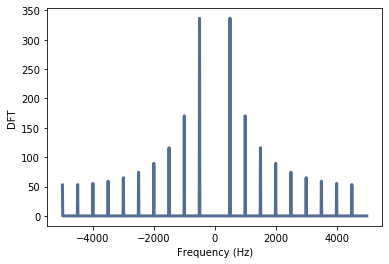

In [52]:
spectrum.plot()
thinkplot.config(xlabel='Frequency (Hz)', ylabel='DFT')